In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Entropy of Real Cell

In [4]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

In [5]:
exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'
dt = 0.01
sampling_rate = 20000

Mean = 10
STD = 2
channelnumbers = [30, 32, 26, 15]
filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(STD)+'_11-Aug-2021_0'
annots = loadmat(exp_folder+filename)
TimeStamps = np.squeeze(annots['TimeStamps'])
# x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
# # x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
# x = x[::int(sampling_rate*dt)]
# x_list[c1] = x.astype(float)

LPOU_Spike_list = [0]*len(channelnumbers)
c2=0
for channelnumber in channelnumbers:
    Spike = np.squeeze( annots['Spikes'][0][channelnumber-1]-TimeStamps[0] )
    Spike = np.delete(Spike, np.where(Spike<=0))
    LPOU_Spike_list[c2] = Spike.copy()
    c2+=1

filename = 'diode_WhiteNoise_mean='+str(Mean)+'_amp='+str(STD)+'_11-Aug-2021_0'
annots = loadmat(exp_folder+filename)
TimeStamps = np.squeeze(annots['TimeStamps'])
# x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
# # x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
# x = x[::int(sampling_rate*dt)]
# x_list[c1] = x.astype(float)

WN_Spike_list = [0]*len(channelnumbers)
c2=0
for channelnumber in channelnumbers:
    Spike = np.squeeze( annots['Spikes'][0][channelnumber-1]-TimeStamps[0] )
    Spike = np.delete(Spike, np.where(Spike<=0))
    WN_Spike_list[c2] = Spike.copy()
    c2+=1

In [6]:
binLen = 0.3*dt
binNum = 10

# binLen = dt
# binNum = 10

for c2 in range(len(channelnumbers)):
    print('ch.'+str(channelnumbers[c2]))
    print('firing rate: '+str(np.round(len(WN_Spike_list[c2])/300,2))+'; '+str(np.round(len(LPOU_Spike_list[c2])/300,2)))
    rstate, _ = np.histogram(WN_Spike_list[c2], np.arange(0,300+binLen,binLen))
    print(Entropy(rstate,binNum))
    rstate, _ = np.histogram(LPOU_Spike_list[c2], np.arange(0,300+binLen,binLen))
    print(Entropy(rstate,binNum))

ch.30
firing rate: 13.36; 11.77
1.7245748573550108
1.5932116727471544
ch.32
firing rate: 0.95; 1.12
0.22787789214803836
0.2818014878380952
ch.26
firing rate: 3.09; 3.87
0.6446813449815191
0.7568410839079033
ch.15
firing rate: 3.1; 3.64
0.49384983856087866
0.5974910205099258


# k_E and k_S

In [7]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [8]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404
# tau_y = 0.001
# gamma,kappa,K,g=1,0.6,22,10

# m = 22
# n =	22
# alpha = 6
# beta = 1.6
# g =  10
# tau_y = 0.05

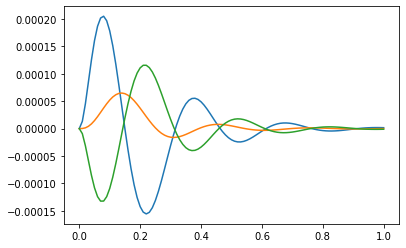

In [9]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

# Simulation Input

In [10]:
tot = 300
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
LPOU = (LPOU-np.mean(LPOU))/np.std(LPOU)

WN = np.random.normal(0,1,size=len(LPOU))

In [11]:
amp = 2
mean = 10

psi = 0.3

eOutput = np.convolve(LPOU*amp+mean, k_E, 'full')[:len(LPOU)]
sOutput = np.convolve(LPOU*amp+mean, k_S, 'full')[:len(LPOU)]
output = -(eOutput*(1-psi)-sOutput*psi)

eOutput = np.convolve(WN*amp+mean, k_E, 'full')[:len(LPOU)]
sOutput = np.convolve(WN*amp+mean, k_S, 'full')[:len(LPOU)]
WNoutput = -(eOutput*(1-psi)-sOutput*psi)


# Information (R_info)

In [12]:
def R_info(rstate_trial, binnum):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy


In [13]:
binLen = dt
binNum = 10

print(Entropy(SG(WNoutput, binLen, 0, 10, 10), binNum))
print(Entropy(SG(output  , binLen, 0, 10, 10), binNum))

4.354061318664093
3.860290232553421


In [19]:
rstates = []
for i in range(10):
    rstates.append(SG(output, binLen, 0, 10, 10))

In [20]:
print(R_info(rstates, binNum))

(4.334460535726084, 1.57390921981783)


# MI and STA

In [24]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

r = output
r = NL(r, np.mean(r))
Xcorr = np.correlate(LPOU, r, 'same') / np.correlate(np.ones_like(LPOU), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [25]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

rstate = SG(output, dt, 0, 10, 10)
timeshift, baseMI = MIfunc(rstate, xstate, dt, window, perSpike = True)

# Subtraction + GC (Gain act on both)

In [26]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

# DCCM

0.05: 0.631; 0.809
0.1: 0.633; 0.809
0.15: 0.636; 0.81
0.2: 0.641; 0.81
0.3: 0.651; 0.811


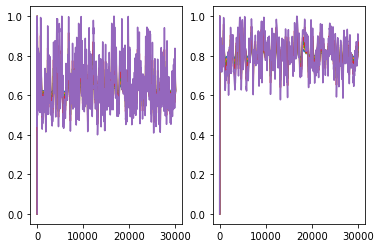

In [27]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 240 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

contrast_list = np.array([0.5,1,1.5,2,3])/mean
DCCM_output = [0]*len(contrast_list)
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    eOutput = np.convolve( (LPOU*contrast_list[i]*mean+mean) , k_E, 'full')[:len(LPOU)]
    sOutput = np.convolve( (LPOU*contrast_list[i]*mean+mean) , k_S, 'full')[:len(LPOU)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e)
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s) # make sure the value of gain is good
    print(str(round(contrast_list[i], 3))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))
    DCCM_output[i] = -eOutput*(1-psi)+sOutput*psi
    

### STA

In [28]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    r = DCCM_output[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

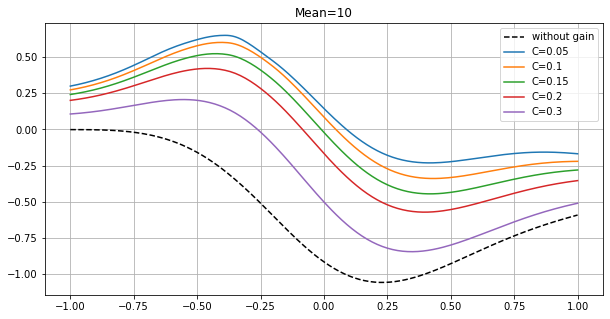

In [29]:
plt.plot(timeaxis,baseXcorr, 'k--', label= 'without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [31]:
DCCM_rstate = [0]*len(contrast_list)
DCCM_MI = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    # rstate, _ = np.histogram( Spike_Time_Generater(DCCM_output[i], dt, 10, 10), np.append(Taxis, tot))
    rstate =SG(DCCM_output[i], dt, 0, 10, 10)
    DCCM_rstate[i] = rstate.copy()
    timeshift, DCCM_MI[i] = MIfunc(rstate, xstate, dt, window, perSpike = True)

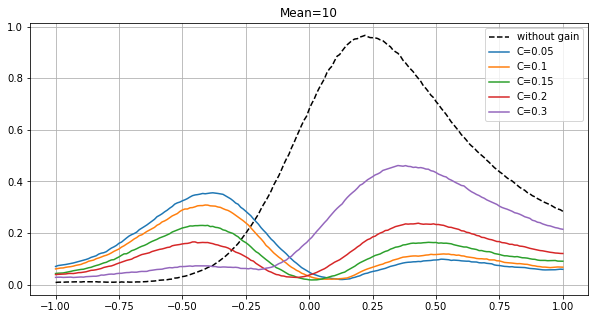

In [33]:
plt.plot(timeaxis,baseMI, 'k--', label= 'without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeshift,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

## R_info

In [40]:
DCCM_Htotal = [0]*len(contrast_list)
DCCM_Hnoise = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    rstates = []
    for j in range(10):
        rstates.append(SG(DCCM_output[i], binLen, 0, 10, 10))
    DCCM_Htotal[i], DCCM_Hnoise[i] = R_info(rstates, binNum)
    print('C='+str(contrast_list[i]))
    print('    H_total='+str(np.round(DCCM_Htotal[i],3))+'    H_noise='+str(np.round(DCCM_Hnoise[i],3)))

C=0.05
    H_total=3.802    H_noise=1.342
C=0.1
    H_total=3.887    H_noise=1.358
C=0.15
    H_total=3.901    H_noise=1.364
C=0.2
    H_total=3.872    H_noise=1.353
C=0.3
    H_total=3.683    H_noise=1.28


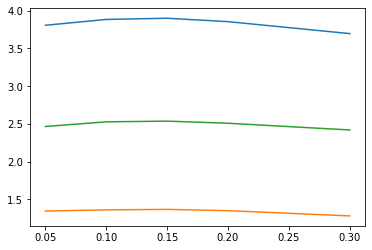

In [35]:
plt.plot(contrast_list, DCCM_Htotal)
plt.plot(contrast_list, DCCM_Hnoise)
plt.plot(contrast_list, np.array(DCCM_Htotal)-np.array(DCCM_Hnoise))